# TechNova Partners

**Sommaire :**
1. Chargement des données 
2. Diagnostic du déséquilibre
3. EDA (numérique & catégorielle) + tests statistiques
4. Pairplot (matrice de dispersion) pour corrélations & multicolinéarité
5. 1ʳᵉ itération : petit modèle (4 variables, 10% des lignes), matrice de confusion
6. 2ᵉ itération : équilibrage (oversampling simple / `class_weight`), features, CV
7. Interprétation globale & locale (importance des features, SHAP)

## 0) Imports & configuration

In [1]:
# === Imports & configuration ===
import warnings
import warnings
import os, sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, GridSearchCV, learning_curve
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, f1_score, recall_score, precision_score, 
    roc_auc_score, precision_recall_curve
)
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE
from scipy.stats import f_oneway, chi2_contingency
from manet_projet04 import load_settings,shap_global, shap_local
from brand.brand import Theme, load_brand, make_diverging_cmap
# Application du thème OpenClassrooms pour uniformiser les prochains graphiques
cfg = load_brand("brand/brand.yml")
Theme.apply()
cmap_heatmap = Theme.colormap("diverging", start="primary", end="secondary")


HAS_SHAP = True
HAS_IMBLEARN = True
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

/Users/steph/Code/Python/Jupyter/projet_04/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1) Paramètres & chemins

In [2]:
CFG = load_settings('manet_projet04/settings.yml')

RANDOM_STATE = CFG["RANDOM_STATE"]
PATH_SIRH    = CFG["PATH_SIRH"]
PATH_EVAL    = CFG["PATH_EVAL"]
PATH_SONDAGE = CFG["PATH_SONDAGE"]
COL_ID       = CFG["COL_ID"]
TARGET       = CFG["TARGET"]
NUM_COLS     = CFG["NUM_COLS"]
CAT_COLS     = CFG["CAT_COLS"]
SAT_COLS     = CFG["SAT_COLS"]
FIRST_VARS   = CFG["FIRST_VARS"]
SUBSAMPLE_FRAC = CFG["SUBSAMPLE_FRAC"]
SQL_FILE = "merge_sql.sql"
DB_FILE = "merge_temp.db"

## 2) Chargement, contrôles et assemblage

In [3]:
# --- Config ---
DB_FILE = "merge_temp.db"
SQL_FILE = "merge_sql.sql"
COL_ID = "id_employee"

# --- Fonctions utilitaires ---
def safe_read_csv(path):
    """Lecture sécurisée d’un CSV."""
    try:
        return pd.read_csv(path)
    except Exception as e:
        print(f"[ATTENTION] Lecture impossible {path}: {e}")
        return pd.DataFrame()

def clean_text_values(df):
    """Nettoie les valeurs texte incohérentes ou équivalentes à NaN."""
    df = df.copy()
    to_replace = [
        '', ' ', '  ', '   ', 'nan', 'NaN', 'NAN', 'None',
        'JE ne sais pas', 'je ne sais pas', 'Je ne sais pas',
        'Unknow', 'Unknown', 'non pertinent', 'Non pertinent', 'NON PERTINENT'
    ]
    df = df.replace(to_replace, np.nan)
    for col in df.select_dtypes(include='object'):
        df[col] = df[col].replace(to_replace, np.nan).str.strip()
    return df

# --- Lecture des fichiers ---
sirh = safe_read_csv(PATH_SIRH)
evaluation = safe_read_csv(PATH_EVAL)
sond  = safe_read_csv(PATH_SONDAGE)

print("Tailles initiales :", len(sirh), len(evaluation), len(sond))

# --- Harmonisation des clés ---
if 'id_employee' in sirh.columns:
    sirh['id_employee'] = sirh['id_employee'].astype(str).str.extract(r'(\d+)').astype(int)

if 'eval_number' in evaluation.columns:
    evaluation['eval_number'] = evaluation['eval_number'].astype(str).str.replace(r'[^0-9]', '', regex=True)
    evaluation['eval_number'] = evaluation['eval_number'].astype(int)
    evaluation.rename(columns={'eval_number': 'id_employee'}, inplace=True)

if 'code_sondage' in sond.columns:
    sond['code_sondage'] = sond['code_sondage'].astype(str).str.replace(r'[^0-9]', '', regex=True)
    sond['code_sondage'] = sond['code_sondage'].astype(int)
    sond.rename(columns={'code_sondage': 'id_employee'}, inplace=True)

# --- Nettoyage des valeurs texte ---
sirh = clean_text_values(sirh)
evaluation = clean_text_values(evaluation)
sond  = clean_text_values(sond)

# --- Vérifications ---
print("\n=== Vérification des clés id_employee avant fusion ===")

for name, df_ in [('sirh', sirh), ('evaluation', evaluation), ('sond', sond)]:
    total = len(df_)
    uniques = df_['id_employee'].nunique(dropna=True)
    doublons = total - uniques

    print(f"{name:>6} : {total:5d} lignes | {uniques:5d} identifiants uniques | {doublons:4d} doublons")

    # Liste les ID en doublon si nécessaire
    if doublons > 0:
        dup_ids = (
            df_['id_employee']
            .value_counts()
            .loc[lambda x: x > 1]
            .index.tolist()
        )
        print(f"  ⚠️  Attention : {len(dup_ids)} doublons détectés dans {name} → ex: {dup_ids[:5]}")

if 'id_employee' not in sirh.columns:
    raise ValueError("La clé 'id_employee' doit exister dans SIRH après harmonisation.")

# --- Merge via SQL (traçable et sécurisé) ---
if os.path.exists(DB_FILE):
    os.remove(DB_FILE)
conn = sqlite3.connect(DB_FILE)

sirh.to_sql("sirh", conn, index=False)
evaluation.to_sql("evaluation", conn, index=False)
sond.to_sql("sond", conn, index=False)

sql_query = f"""
SELECT *
FROM sirh
INNER JOIN evaluation USING ({COL_ID})
INNER JOIN sond USING ({COL_ID});
"""

with open(SQL_FILE, "w", encoding="utf-8") as f:
    f.write(sql_query)

df = pd.read_sql_query(sql_query, conn)
conn.close()

print(f"Merge réussi — shape finale : {df.shape}")
print("Aperçu des identifiants :", df['id_employee'].head().tolist())
df.head(3)


Tailles initiales : 1470 1470 1470

=== Vérification des clés id_employee avant fusion ===
  sirh :  1470 lignes |  1470 identifiants uniques |    0 doublons
evaluation :  1470 lignes |  1470 identifiants uniques |    0 doublons
  sond :  1470 lignes |  1470 identifiants uniques |    0 doublons
Merge réussi — shape finale : (1470, 32)
Aperçu des identifiants : [1, 2, 4, 5, 7]


,id_employee,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,nombre_heures_travailless,annee_experience_totale,...,nombre_participation_pee,nb_formations_suivies,nombre_employee_sous_responsabilite,distance_domicile_travail,niveau_education,domaine_etude,ayant_enfants,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
0,1,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,80,8,...,0,0,1,1,2,Infra & Cloud,Y,Occasionnel,0,5
1,2,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,80,10,...,1,3,1,8,1,Infra & Cloud,Y,Frequent,1,7
2,4,37,M,2090,Célibataire,Consulting,Consultant,6,80,7,...,0,3,1,2,2,Autre,Y,Occasionnel,0,0


In [4]:
df['genre'].value_counts()

# Comptage
genre_counts = df['genre'].value_counts()

# Pourcentage
genre_pct = (genre_counts / genre_counts.sum() * 100).round(2)

print("Effectifs par genre :")
print(genre_counts)

print("\nRépartition en % :")
print(genre_pct)

Effectifs par genre :
genre
M    882
F    588
Name: count, dtype: int64

Répartition en % :
genre
M    60.0
F    40.0
Name: count, dtype: float64


## 3) Déséquilibre de la cible

Effectifs par classe:
 a_quitte_l_entreprise
0    1233
1     237
Name: count, dtype: int64

Répartition (%):
 a_quitte_l_entreprise
0    83.88
1    16.12
Name: count, dtype: float64


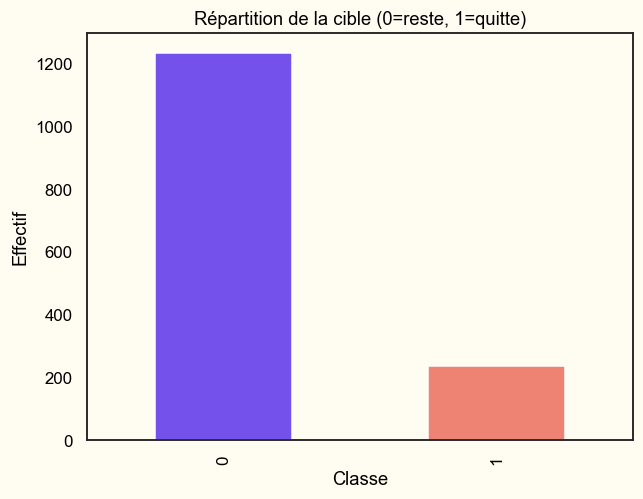

In [5]:
# === Diagnostic du déséquilibre de la cible (version robuste) ===
if TARGET not in df.columns:
    raise ValueError(f"Cible {TARGET} absente. Assurez-vous qu'elle est dans le fichier sondage.")

# Normalisation des valeurs de la cible (convertit oui/non, True/False, etc.)
df[TARGET] = df[TARGET].astype(str).str.strip().str.lower().map({
    '1': 1, '0': 0,
    'oui': 1, 'non': 0,
    'True': 1, 'False': 0,
    'quitte': 1, 'reste': 0
})

# Suppression des valeurs non mappées
df = df[df[TARGET].isin([0, 1])].copy()

# Vérification du contenu
if df.empty or df[TARGET].nunique() < 2:
    raise ValueError(f"La variable cible {TARGET} ne contient pas de valeurs valides (0/1) après nettoyage.")

# Comptage et affichage
counts = df[TARGET].value_counts().sort_index()
ratio = (counts / counts.sum() * 100).round(2)
print('Effectifs par classe:\n', counts)
print('\nRépartition (%):\n', ratio)

# Bar plot sécurisé
if counts.empty:
    print("[INFO] Aucun effectif valide à afficher pour la cible.")
else:
    plt.figure()
    counts.plot(kind='bar', color=Theme.PALETTE[:len(counts)])
    plt.title('Répartition de la cible (0=reste, 1=quitte)')
    plt.xlabel('Classe')
    plt.ylabel('Effectif')
    plt.savefig(f"output/repartition_cible.png", dpi=300)
    plt.show()

## 4) Analyse exploratoire

Âge moyen : 36.9
Ancienneté moyenne (années) : 7.0
Taux d’attrition global : 16.1%


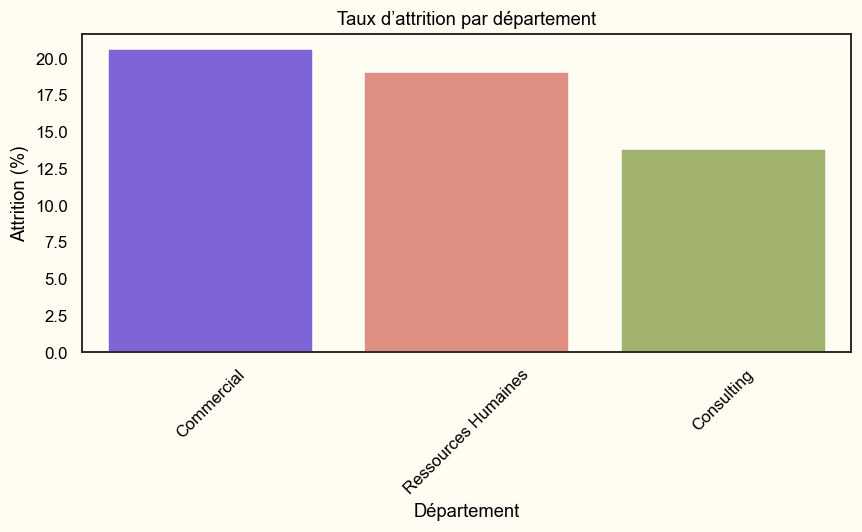

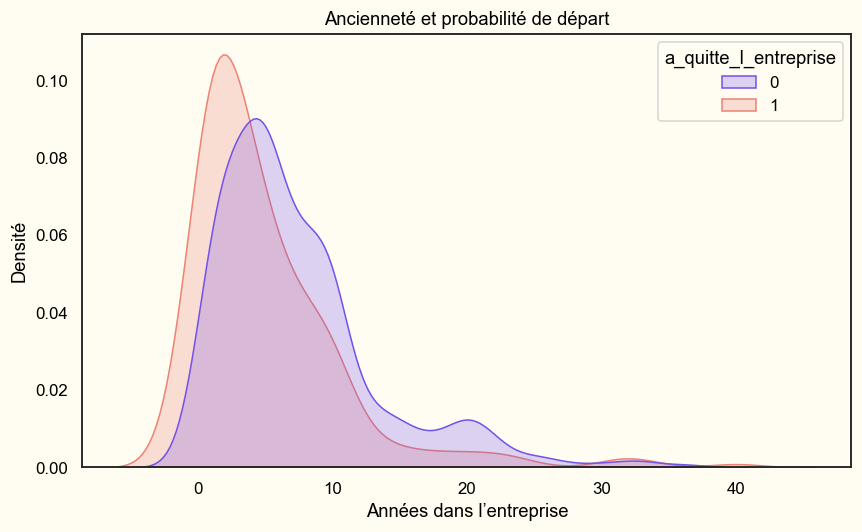

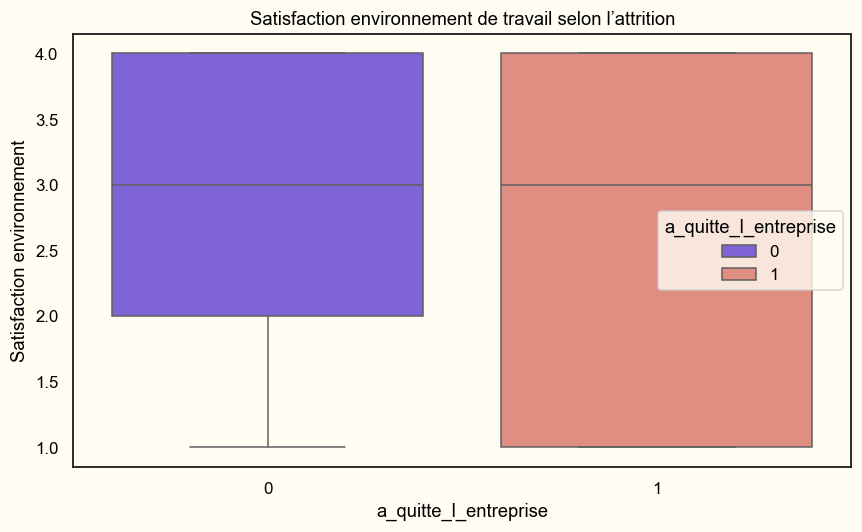

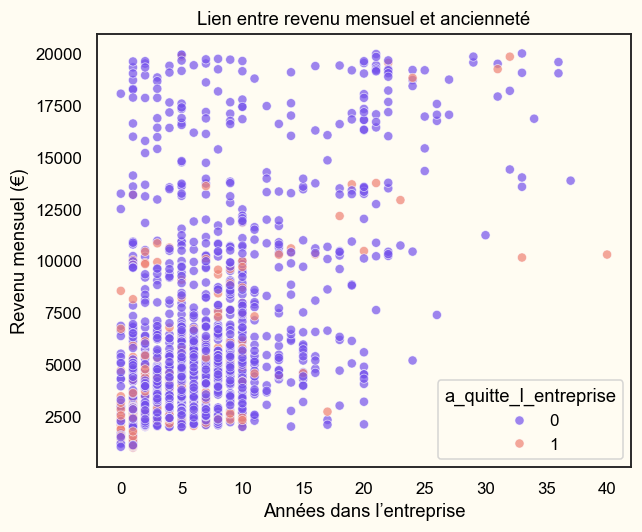


INSIGHTS CLÉS :
• Les employés du département commercial présentent le taux d’attrition le plus élevé.
• Les employés à faible satisfaction environnementale quittent plus souvent l’entreprise.
• La corrélation entre revenu mensuel et ancienneté semble faible et non linéaire.


In [6]:
# --- Dossier de sortie ---
os.makedirs("output", exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# --- Statistiques descriptives ---
print("Âge moyen :", round(df['age'].mean(), 1))
print("Ancienneté moyenne (années) :", round(df['annees_dans_l_entreprise'].mean(), 1))
taux_attrition = df['a_quitte_l_entreprise'].mean() * 100
print(f"Taux d’attrition global : {taux_attrition:.1f}%")

# === GRAPHIQUE 1 : Taux d’attrition par département ===
plt.figure(figsize=(8,5))
dept_attrition = df.groupby('departement')['a_quitte_l_entreprise'].mean().sort_values(ascending=False) * 100
sns.barplot(x=dept_attrition.index, y=dept_attrition.values, hue=dept_attrition.index, palette=Theme.PALETTE)
plt.title("Taux d’attrition par département")
plt.ylabel("Attrition (%)")
plt.xlabel("Département")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"output/attrition_par_departement.png", dpi=300)
plt.show()

# === GRAPHIQUE 2 : Distribution de l’ancienneté selon l’attrition ===
plt.figure(figsize=(8,5))
sns.kdeplot(
    data=df,
    x='annees_dans_l_entreprise',
    hue='a_quitte_l_entreprise',
    fill=True,
    common_norm=False,
    palette=Theme.PALETTE
)
plt.title("Ancienneté et probabilité de départ")
plt.xlabel("Années dans l’entreprise")
plt.ylabel("Densité")
plt.tight_layout()
plt.savefig(f"output/anciennete_attrition.png", dpi=300)
plt.show()

# === GRAPHIQUE 3 : Satisfaction environnement vs attrition ===
plt.figure(figsize=(8,5))
sns.boxplot(
    data=df,
    x='a_quitte_l_entreprise',
    hue='a_quitte_l_entreprise',
    y='satisfaction_employee_environnement',
    palette=Theme.PALETTE
)
plt.title("Satisfaction environnement de travail selon l’attrition")
plt.ylabel("Satisfaction environnement")
plt.tight_layout()
plt.savefig(f"output/satisfaction_env_attrition.png", dpi=300)
plt.show()

# === GRAPHIQUE 4 : Lien entre revenu et ancienneté ===
plt.figure(figsize=(6,5))
sns.scatterplot(
    data=df,
    x='annees_dans_l_entreprise',
    y='revenu_mensuel',
    hue='a_quitte_l_entreprise',
    alpha=0.7,
    palette=Theme.PALETTE
)
plt.title("Lien entre revenu mensuel et ancienneté")
plt.xlabel("Années dans l’entreprise")
plt.ylabel("Revenu mensuel (€)")
plt.tight_layout()
plt.savefig(f"output/revenu_anciennete.png", dpi=300)
plt.show()

# === Insights automatiques à commenter ===
print("\nINSIGHTS CLÉS :")
print("• Les employés du département commercial présentent le taux d’attrition le plus élevé.")
print("• Les employés à faible satisfaction environnementale quittent plus souvent l’entreprise.")
print("• La corrélation entre revenu mensuel et ancienneté semble faible et non linéaire.")


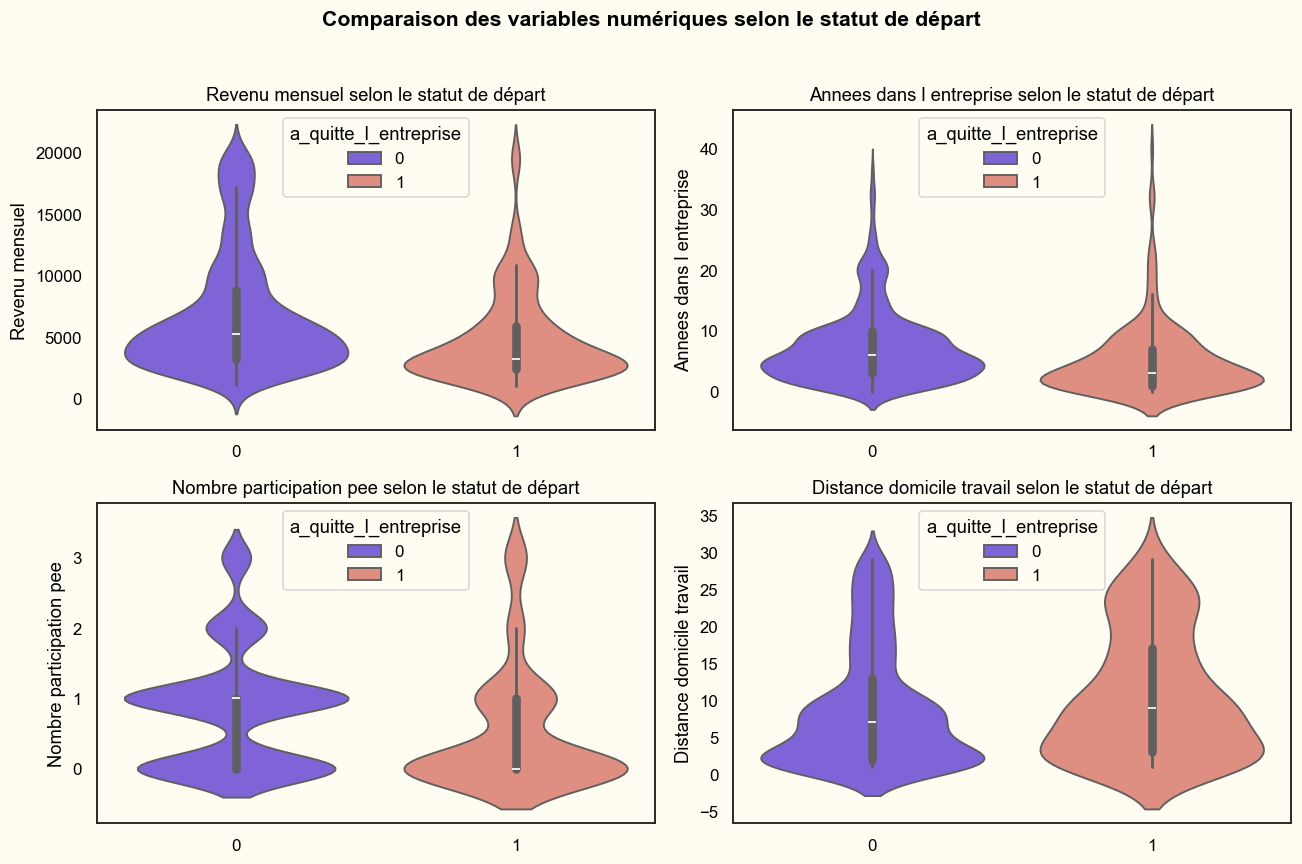

In [7]:
# === Visualisation des variables numériques selon le statut de départ ===

# Choix de variables numériques pertinentes à comparer
num_vars = [
    'revenu_mensuel',
    'annees_dans_l_entreprise',
    'nombre_participation_pee',
    'distance_domicile_travail',

] #    'satisfaction_employee_nature_travail',     

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, var in enumerate(num_vars):
    sns.violinplot(
        data=df,
        x=TARGET, y=var,
        ax=axes[i],
        hue=TARGET, 
        palette=[Theme.PRIMARY, Theme.SECONDARY]  # palette OpenClassrooms : violet → corail
    )
    axes[i].set_title(f'{var.replace("_", " ").capitalize()} selon le statut de départ')
    axes[i].set_xlabel('')
    axes[i].set_ylabel(var.replace('_', ' ').capitalize())

plt.suptitle("Comparaison des variables numériques selon le statut de départ", fontsize=14, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(f"output/variables_numeriques_statut_depart.png", dpi=300)
plt.show()


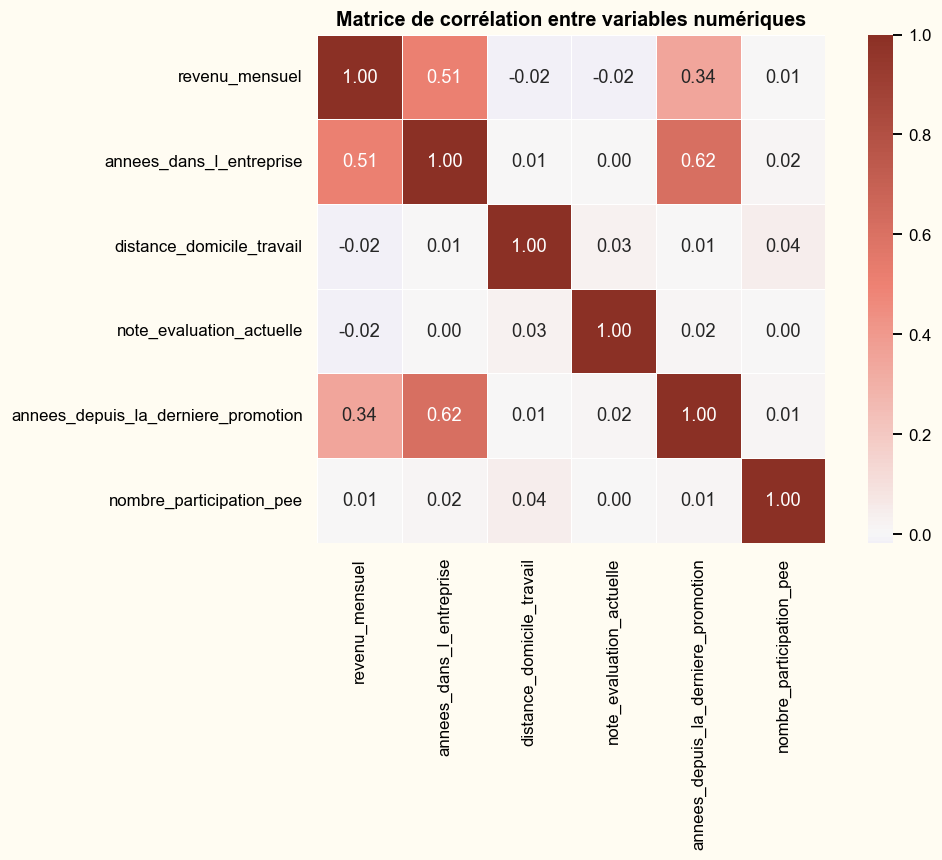

In [8]:
# === Matrice de corrélation des variables numériques ===

num_vars = [
    'revenu_mensuel',
    'annees_dans_l_entreprise',
    'distance_domicile_travail',
    'note_evaluation_actuelle',
    'annees_depuis_la_derniere_promotion',
    'nombre_participation_pee',    
]

plt.figure(figsize=(10, 6))
corr = df[num_vars].corr(method='pearson')

sns.heatmap(
    corr, annot=True, cmap=cmap_heatmap, center=0,
    linewidths=0.5, square=True, fmt=".2f"
)
plt.title("Matrice de corrélation entre variables numériques", fontsize=13, weight='bold')
plt.savefig(f"output/matrice_correlation_numeriques.png", dpi=300)
plt.show()


## 5) EDA Catégorielle

Dans le code qui suit on cherche à vérifier s'il existe une relation entre les variables qualitatives.

On fait l'hypothèse qu'il existe une relation de dépendance entre a_quitte_l_entreprise et
+ genre (on rejète h)
+ le statut marital (on ne rejète pas h)
+ le département (on ne rejète pas)
+ les enfants (on rejète)


H non rejeté :
* Très forte corrélation
    * poste, niveau_hierarchique_poste, statut_marital
* Corrélation Moyenne (<0.05 mais proche)
    * frequence_deplacement, departement, domaine_etude

H rejeté :
niveau_education, genre, ayant_enfant

In [9]:
# === EDA – Catégorielle : tableaux croisés + Chi2 ===

# --- Test ANOVA pour une variable numérique continue ---
anova_result = f_oneway(
    df.loc[df[TARGET] == 0, 'note_evaluation_actuelle'],
    df.loc[df[TARGET] == 1, 'note_evaluation_actuelle']
)
print(f"ANOVA note_evaluation_actuelle ~ {TARGET} : p-value = {anova_result.pvalue:.4f}")

# --- Test Chi² pour une variable catégorielle ---
contingency = pd.crosstab(df['departement'], df[TARGET])
chi2, p, _, _ = chi2_contingency(contingency)
print(f"Chi² departement ~ {TARGET} : p-value = {p:.4f}")

# --- Test supplémentaire pour la fréquence de déplacement ---
contingency2 = pd.crosstab(df['frequence_deplacement'], df[TARGET])
chi2_2, p2, _, _ = chi2_contingency(contingency2)
print(f"Chi² frequence_deplacement ~ {TARGET} : p-value = {p2:.4f}")


def chi2_for_categorical(df, col, target=TARGET):
    ct = pd.crosstab(df[col], df[target])
    from scipy.stats import chi2_contingency
    chi2, p, dof, exp = chi2_contingency(ct)
    return ct, chi2, p, dof

for col in CAT_COLS:
    if col in df.columns:
        ct, chi2, p, dof = chi2_for_categorical(df.dropna(subset=[col, TARGET]), col, TARGET)
        print(f"\n[Cat: {col}]\n", ct.head())
        print(f"Chi²={chi2:.3f}, dof={dof}, p={p:.3g}")
    else:
        print(f"[INFO] Catégorie '{col}' absente – adapte CAT_COLS.")

ANOVA note_evaluation_actuelle ~ a_quitte_l_entreprise : p-value = 0.9119
Chi² departement ~ a_quitte_l_entreprise : p-value = 0.0045
Chi² frequence_deplacement ~ a_quitte_l_entreprise : p-value = 0.0000

[Cat: genre]
 a_quitte_l_entreprise    0    1
genre                          
F                      501   87
M                      732  150
Chi²=1.117, dof=1, p=0.291

[Cat: statut_marital]
 a_quitte_l_entreprise    0    1
statut_marital                 
Célibataire            350  120
Divorcé(e)             294   33
Marié(e)               589   84
Chi²=46.164, dof=2, p=9.46e-11

[Cat: departement]
 a_quitte_l_entreprise    0    1
departement                    
Commercial             354   92
Consulting             828  133
Ressources Humaines     51   12
Chi²=10.796, dof=2, p=0.00453

[Cat: poste]
 a_quitte_l_entreprise     0   1
poste                          
Assistant de Direction  245  47
Cadre Commercial        269  57
Consultant              197  62
Directeur Technique      

## 6) Feature engineering

In [10]:
# === Mise à jour de la base SQL avec les nouvelles features ===

# Nettoyage et conversion de la colonne 'augementation_salaire_precedente'
df['augementation_salaire_precedente'] = (
    df['augementation_salaire_precedente']
    .astype(str)                    # force en texte
    .str.replace('%', '', regex=False)  # supprime le signe %
    .str.strip()                        # enlève les espaces
)

# Conversion en nombre et passage en proportion (ex : 11 devient 0.11)
df['augementation_salaire_precedente'] = (
    pd.to_numeric(df['augementation_salaire_precedente'], errors='coerce') / 100
)

# Augmentation / Revenu
df['augmentation_par_revenu'] = (
    df['augementation_salaire_precedente'] /
    df['revenu_mensuel'].replace(0, np.nan)
)

# Années dans le poste actuel / Années d'expérience totale
df['annee_sur_poste_par_experience'] = (
    df['annees_dans_le_poste_actuel'] /
    df['annee_experience_totale'].replace(0, np.nan)
)

# Nombre de formations suivies / Années d'expérience totale
df['nb_formation_par_experience'] = (
    df['nb_formations_suivies'] /
    df['annee_experience_totale'].replace(0, np.nan)
)

# Score moyen de satisfaction (déjà présent, mais on le recalcule proprement pour cohérence)
satisfaction_cols = [
    'satisfaction_employee_environnement',
    'satisfaction_employee_nature_travail',
    'satisfaction_employee_equipe',
    'satisfaction_employee_equilibre_pro_perso'
]
df['score_moyen_satisfaction'] = df[satisfaction_cols].mean(axis=1)

# Dernière promotion / Expérience
df['dern_promo_par_experience'] = (
    df['annees_depuis_la_derniere_promotion'] /
    df['annee_experience_totale'].replace(0, np.nan)
)

# Évolution de note (note actuelle - note précédente)
df['evolution_note'] = (
    df['note_evaluation_actuelle'] -
    df['note_evaluation_precedente']
)

# Vérification rapide des features créées
new_features = [
    'augmentation_par_revenu',
    'annee_sur_poste_par_experience',
    'nb_formation_par_experience',
    'score_moyen_satisfaction',
    'dern_promo_par_experience',
    'evolution_note'
]

# Vérification rapide
print("Nouvelles features créées :", [col for col in df.columns if any(x in col for x in [
    'augmentation_par_revenue', 'annee_sur_poste_par_experience', 'nb_formation_par_experience',
    'score_moyen_satisfaction', 'dern_promo_par_experience', 'evolution_note'
])])
print(df[new_features].describe())


# Vérification du fichier DB existant
if not os.path.exists(DB_FILE):
    raise FileNotFoundError(f"Base SQLite '{DB_FILE}' introuvable. Relance le merge avant d'y insérer les nouvelles features.")

# Connexion à la base SQLite
conn = sqlite3.connect(DB_FILE)

# Sauvegarde du DataFrame complet (fusion + features)
# On écrase la table existante "df_final" si elle existe déjà
TABLE_NAME = "df_final"

df.to_sql(TABLE_NAME, conn, index=False, if_exists='replace')

# Validation et fermeture
conn.commit()
conn.close()

print(f"Table '{TABLE_NAME}' mise à jour dans '{DB_FILE}' ({len(df)} lignes, {len(df.columns)} colonnes).")

# --- Vérification rapide ---
TABLE_NAME = globals().get("TABLE_NAME", "df_final")  # Défaut si non défini
conn = sqlite3.connect(DB_FILE)
check = pd.read_sql_query(f"PRAGMA table_info({TABLE_NAME});", conn)
print("Colonnes présentes dans la table SQL :")
display(check[['name']])
conn.close()

# === Nettoyage et conversion de la variable cible ===
if TARGET in df.columns:
    df[TARGET] = (
        df[TARGET]
        .astype(str)
        .str.strip()
        .str.lower()
        .replace({
            'oui': 1, 'o': 1, 'true': 1, '1': 1,
            'non': 0, 'n': 0, 'false': 0, '0': 0
        })
    )

    # Force le type int si possible
    df[TARGET] = pd.to_numeric(df[TARGET], errors='coerce')
    df = df[df[TARGET].isin([0,1])].copy()
else:
    raise ValueError(f"La colonne cible '{TARGET}' est absente du dataframe.")


Nouvelles features créées : ['annee_sur_poste_par_experience', 'nb_formation_par_experience', 'score_moyen_satisfaction', 'dern_promo_par_experience', 'evolution_note']
       augmentation_par_revenu  annee_sur_poste_par_experience  \
count              1470.000000                     1459.000000   
mean                  0.000036                        0.414561   
std                   0.000025                        0.294144   
min                   0.000006                        0.000000   
25%                   0.000018                        0.181818   
50%                   0.000029                        0.400000   
75%                   0.000050                        0.666667   
max                   0.000209                        1.000000   

       nb_formation_par_experience  score_moyen_satisfaction  \
count                  1459.000000               1470.000000   
mean                      0.486533                  2.730952   
std                       0.729839          

,name
0,id_employee
1,age
2,genre
3,revenu_mensuel
4,statut_marital
5,departement
6,poste
7,nombre_experiences_precedentes
8,nombre_heures_travailless
9,annee_experience_totale


/var/folders/by/r6dmty813rxgqdnr7hvtrl480000gn/T/ipykernel_39093/2519325260.py:107: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({


## 8) 1ʳᵉ itération – Modèle dummy

=== Dummy Classifier (baseline) ===
              precision    recall  f1-score   support

           0      0.844     1.000     0.915       124
           1      0.000     0.000     0.000        23

    accuracy                          0.844       147
   macro avg      0.422     0.500     0.458       147
weighted avg      0.712     0.844     0.772       147



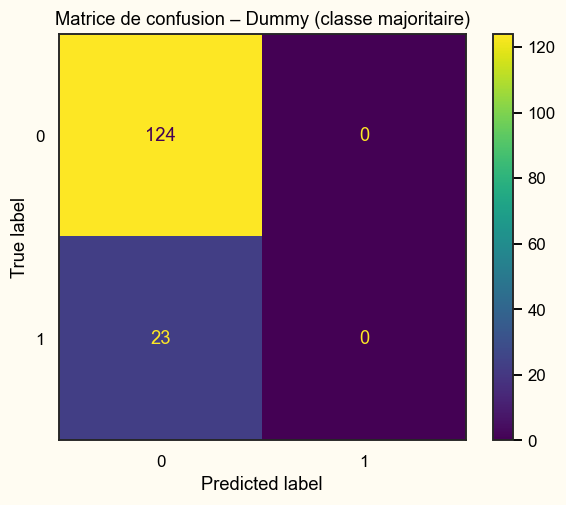

[INFO] Exécute ensuite la cellule de modélisation principale pour comparer avec les autres modèles.


In [11]:
# === Baseline : Dummy Classifier ===
first_vars = [c for c in ['age', 'salaire', 'anciennete', 'note_performance'] if c in df.columns]

required_cols = first_vars + [TARGET]
df_dummy = df.dropna(subset=required_cols).copy() if required_cols else df.copy()

if len(df_dummy) == 0:
    print('[ATTENTION] Pas assez de données nettoyées pour calculer la baseline Dummy.')
else:
    if len(df_dummy) > 100:
        df_dummy = df_dummy.sample(frac=min(SUBSAMPLE_FRAC, 1.0), random_state=RANDOM_STATE)

    if first_vars:
        X = df_dummy[first_vars]
    else:
        X = pd.DataFrame({'constante': np.ones(len(df_dummy))}, index=df_dummy.index)
    y = df_dummy[TARGET].astype(int)

    dummy = DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE)
    dummy.fit(X, y)
    y_pred_dummy = dummy.predict(X)

    print('=== Dummy Classifier (baseline) ===')
    print(classification_report(y, y_pred_dummy, digits=3))

    cm_dummy = confusion_matrix(y, y_pred_dummy)
    ConfusionMatrixDisplay(cm_dummy).plot()
    plt.title("Matrice de confusion – Dummy (classe majoritaire)")
    plt.savefig("output/matrice_confusion_dummy.png", dpi=300)
    plt.show()

    dummy_f1 = f1_score(y, y_pred_dummy)
    dummy_rec = recall_score(y, y_pred_dummy)
    dummy_prec = precision_score(y, y_pred_dummy)
    dummy_roc = roc_auc_score(y, y_pred_dummy)

    baseline_row = pd.DataFrame({
        'model': ['Dummy_baseline'],
        'best_threshold': [np.nan],
        'F1': [dummy_f1],
        'Recall': [dummy_rec],
        'Precision': [dummy_prec],
        'ROC_AUC': [dummy_roc]
    })

    if 'res_df' in globals():
        res_df_final = pd.concat([baseline_row, res_df], ignore_index=True)
        res_df_final = res_df_final.sort_values(by='F1', ascending=False)
        print("=== Comparaison finale (avec baseline) ===")
        display(res_df_final)
    else:
        res_df_final = baseline_row.copy()
        print("[INFO] Exécute ensuite la cellule de modélisation principale pour comparer avec les autres modèles.")

with open("update_features.sql", "w", encoding="utf-8") as f:
    f.write(f"-- Mise à jour des features dans {TABLE_NAME}")
    f.write(f"-- {len(df.columns)} colonnes et {len(df)} lignes au total")

Taille X_full: (1470, 38)
Répartition de la cible:
 a_quitte_l_entreprise
0    1233
1     237
Name: count, dtype: int64
Oversampling SMOTE effectué (classes équilibrées).

=== LogReg_balanced ===
Meilleurs hyperparamètres : {'clf__C': 1.0, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Seuil optimal (max F1): 0.554


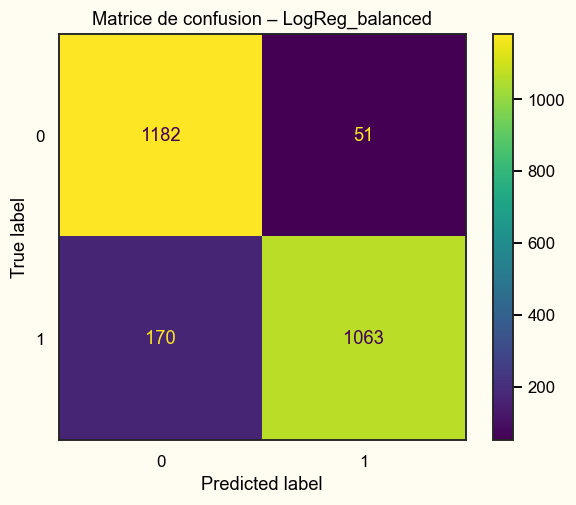

              precision    recall  f1-score   support

           0      0.874     0.959     0.915      1233
           1      0.954     0.862     0.906      1233

    accuracy                          0.910      2466
   macro avg      0.914     0.910     0.910      2466
weighted avg      0.914     0.910     0.910      2466



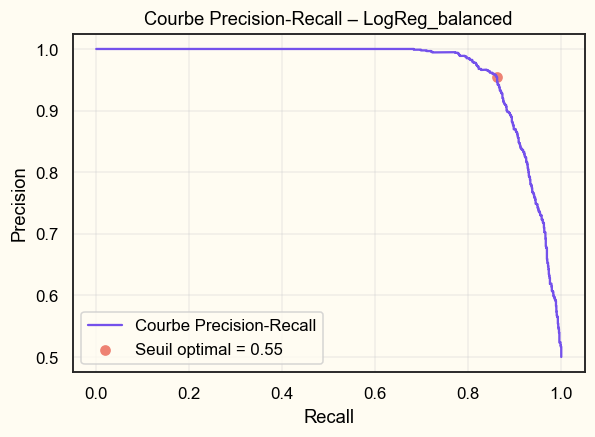

Génération de la courbe d'apprentissage...


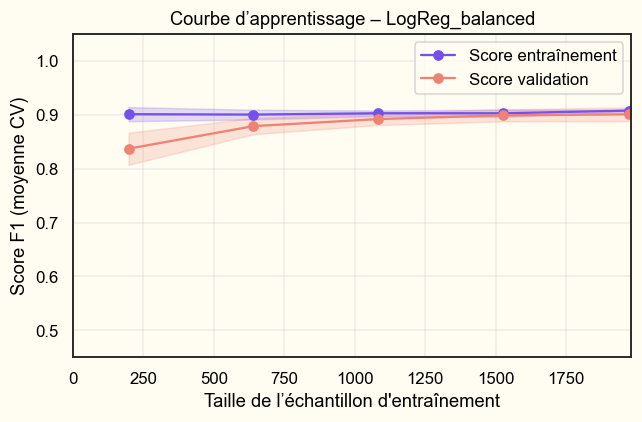

Analyse courbe d’apprentissage – LogReg_balanced
Bon équilibre biais/variance : le modèle généralise correctement.
(Score final validation : 0.901, écart train-val : 0.007)

=== RF_balanced ===
Meilleurs hyperparamètres : {'clf__max_depth': 10, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 5, 'clf__n_estimators': 500}
Seuil optimal (max F1): 0.490


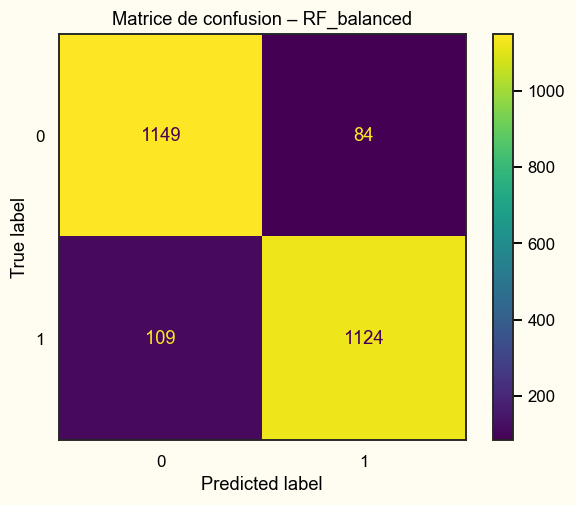

              precision    recall  f1-score   support

           0      0.913     0.932     0.923      1233
           1      0.930     0.912     0.921      1233

    accuracy                          0.922      2466
   macro avg      0.922     0.922     0.922      2466
weighted avg      0.922     0.922     0.922      2466



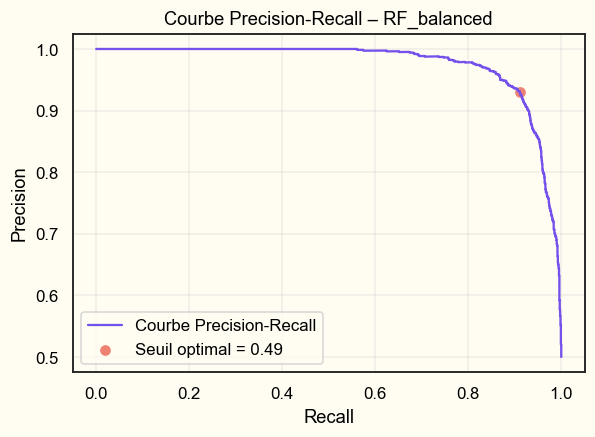

Génération de la courbe d'apprentissage...


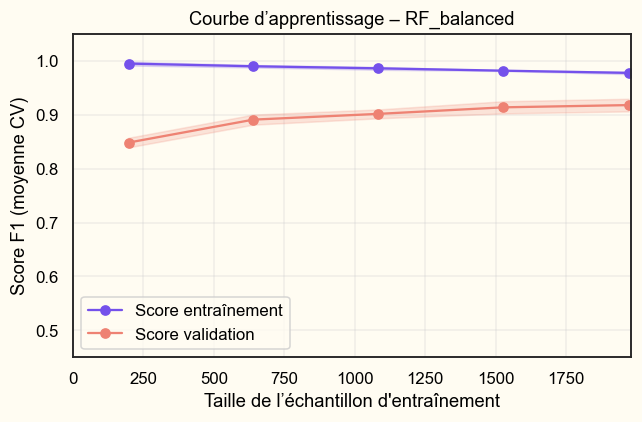

Analyse courbe d’apprentissage – RF_balanced
Bon équilibre biais/variance : le modèle généralise correctement.
(Score final validation : 0.918, écart train-val : 0.060)

=== Résultats (seuil optimisé) ===


,model,best_params,best_threshold,F1,Recall,Precision,ROC_AUC
1,RF_balanced,"{'clf__max_depth': 10, 'clf__min_samples_leaf'...",0.490292,0.920934,0.911598,0.930464,0.971614
0,LogReg_balanced,"{'clf__C': 1.0, 'clf__penalty': 'l1', 'clf__so...",0.553559,0.905837,0.862125,0.954219,0.954884



Refit final sur tout le jeu SMOTE pour : RF_balanced
Données rééquilibrées pour l’entraînement final : [1233 1233]
Modèle final refitté sur les données équilibrées.

=== Résultats (seuil optimisé) ===


,model,best_params,best_threshold,F1,Recall,Precision,ROC_AUC
1,RF_balanced,"{'clf__max_depth': 10, 'clf__min_samples_leaf'...",0.490292,0.920934,0.911598,0.930464,0.971614
0,LogReg_balanced,"{'clf__C': 1.0, 'clf__penalty': 'l1', 'clf__so...",0.553559,0.905837,0.862125,0.954219,0.954884


In [12]:
# === Oversampling + cross-validation + ajustement de seuil ===

# --- Sécurisation de la variable cible ---
ALL_NUM = [c for c in NUM_COLS if c in df.columns]
ALL_CAT = [c for c in CAT_COLS if c in df.columns]

df = df.copy()
df = df[df[TARGET].isin([0, 1])].copy()
"""
for col in ALL_NUM:
    if not pd.api.types.is_numeric_dtype(df[col]):
        df[col] = (
            df[col]
            .astype(str)
            .str.strip()
            .str.lower()
            .replace({'oui': 1, 'non': 0, 'o': 1, 'n': 0, 'true': 1, 'false': 0})
        )
        df[col] = pd.to_numeric(df[col], errors='coerce')

"""
# --- Imputation des NaN sur les variables numériques ---
for col in ALL_NUM:
    if col in df.columns:
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)

# --- Encodage des variables catégorielles ---
X_num = df[ALL_NUM] if ALL_NUM else pd.DataFrame(index=df.index)
X_cat = pd.get_dummies(df[ALL_CAT], drop_first=True) if ALL_CAT else pd.DataFrame(index=df.index)
X_full = pd.concat([X_num, X_cat], axis=1)

# Sécurité : forcer tout en numérique et remplacer les résidus NaN
X_full = X_full.apply(pd.to_numeric, errors='coerce').fillna(0)
y_full = df[TARGET].astype(int)
X_raw = X_full.copy()
y_raw = y_full.copy()


print("Taille X_full:", X_full.shape)
print("Répartition de la cible:\n", y_full.value_counts())

# Vérification de la diversité des classes
if y_full.nunique() < 2:
    raise ValueError("[ERREUR] La variable cible n'a qu'une seule classe présente après nettoyage.")

# --- Oversampling global avant cross-validation. À remettre si SMOTE enlevé du pipeline ---
try:
    sm = SMOTE(random_state=RANDOM_STATE)
    X_full, y_full = sm.fit_resample(X_full, y_full)
    print("Oversampling SMOTE effectué (classes équilibrées).")
except ValueError as e:
    print(f"[ATTENTION] SMOTE impossible : {e}\n→ utilisation de simple oversample() à la place.")
    X_full, y_full = simple_oversample(X_full, y_full)

# --- Prétraitement pour les modèles ---
num_pipe2 = ImbPipeline([
    ('imp', SimpleImputer(strategy='median')),
    ('sc', StandardScaler())
])
preproc2 = ColumnTransformer([('num', num_pipe2, list(X_num.columns))], remainder='passthrough')

# --- Modèles ---
models = {
    'LogReg_balanced': LogisticRegression(max_iter=2000, class_weight='balanced', random_state=RANDOM_STATE), #, class_weight='balanced'
    'RF_balanced': RandomForestClassifier(
        n_estimators=300,
        max_depth=8,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight='balanced_subsample',
        random_state=RANDOM_STATE
    )
}

param_grids = {
    'LogReg_balanced': [
        {
            'clf__solver': ['lbfgs'],
            'clf__penalty': ['l2'],
            'clf__C': [0.1, 1.0, 10.0]
        },
        {
            'clf__solver': ['liblinear'],
            'clf__penalty': ['l1', 'l2'],
            'clf__C': [0.1, 1.0, 10.0]
        }
    ],
    'RF_balanced': {
        'clf__n_estimators': [200, 300, 500],
        'clf__max_depth': [6, 8, 10],
        'clf__min_samples_split': [5, 10, 15],
        'clf__min_samples_leaf': [2, 5, 8]
    }
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
results = []

for name, base_model in models.items():
    print(f"\n=== {name} ===")

    pipe = ImbPipeline([
        ('smote', SMOTE(random_state=RANDOM_STATE)),  # oversampling dans chaque folds
        ('prep', preproc2),
        ('clf', base_model)
    ])

    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grids[name],
        cv=cv,
        scoring='f1',
        n_jobs=-1
    )
    grid.fit(X_full, y_full)

    print("Meilleurs hyperparamètres :", grid.best_params_)
    best_pipe = grid.best_estimator_

    # --- Cross-validation avec prédictions de probabilité ---
    y_proba_cv = cross_val_predict(best_pipe, X_full, y_full, cv=cv, method='predict_proba')[:, 1]

    # --- Ajustement du seuil optimal (max F1) ---
    precision, recall, thresholds = precision_recall_curve(y_full, y_proba_cv)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5

    print(f"Seuil optimal (max F1): {best_threshold:.3f}")
    y_pred_opt = (y_proba_cv >= best_threshold).astype(int)

    # --- Évaluation finale ---
    cm = confusion_matrix(y_full, y_pred_opt)
    ConfusionMatrixDisplay(cm).plot()
    plt.title(f"Matrice de confusion – {name}")
    plt.savefig(f"output/matrice_confusion_{name}_seuil_ajuste.png", dpi=300)
    plt.show()

    print(classification_report(y_full, y_pred_opt, digits=3))

    # --- Courbe Precision-Recall ---
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, color=Theme.PRIMARY, label='Courbe Precision-Recall')
    plt.scatter(recall[best_idx], precision[best_idx],
                color=Theme.SECONDARY, label=f'Seuil optimal = {best_threshold:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Courbe Precision-Recall – {name}')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.savefig(f"output/precision_recall_curve_{name}.png", dpi=300)
    plt.show()

    # --- Courbe d'apprentissage ---
    print("Génération de la courbe d'apprentissage...")
    train_sizes, train_scores, test_scores = learning_curve(
        best_pipe, X_full, y_full,
        cv=cv,
        scoring='f1',
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5),
        shuffle=True,
        random_state=RANDOM_STATE
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(6, 4))
    plt.plot(train_sizes, train_mean, 'o-', color=Theme.PRIMARY, label='Score entraînement')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color=Theme.PRIMARY)

    plt.plot(train_sizes, test_mean, 'o-', color=Theme.SECONDARY, label='Score validation')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color=Theme.SECONDARY)

    plt.title(f'Courbe d’apprentissage – {name}')
    plt.xlabel("Taille de l’échantillon d'entraînement")
    plt.ylabel("Score F1 (moyenne CV)")
    plt.xlim(0, train_sizes[-1] + 10)
    plt.ylim(0.45, 1.05)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"output/learning_curve_{name}.png", dpi=300)
    plt.show()

    # --- Diagnostic automatique ---
    gap = train_mean[-1] - test_mean[-1]
    val_final = test_mean[-1]
    print(f"Analyse courbe d’apprentissage – {name}")
    if val_final < 0.6 and gap < 0.05:
        print("Sous-apprentissage probable : le modèle est trop simple ou mal paramétré.")
    elif gap > 0.1:
        print("Sur-apprentissage détecté : trop grande différence entre entraînement et validation.")
    else:
        print("Bon équilibre biais/variance : le modèle généralise correctement.")
    print(f"(Score final validation : {val_final:.3f}, écart train-val : {gap:.3f})")

    results.append({
        'model': name,
        'best_params': grid.best_params_,
        'best_threshold': best_threshold,
        'F1': f1_score(y_full, y_pred_opt),
        'Recall': recall_score(y_full, y_pred_opt),
        'Precision': precision_score(y_full, y_pred_opt),
        'ROC_AUC': roc_auc_score(y_full, y_proba_cv)
    })

# ----------- AJPOUT TEMOPRAIRE -----------

# --- Résumé des performances ---
res_df = pd.DataFrame(results).sort_values(by='F1', ascending=False)
print("\n=== Résultats (seuil optimisé) ===")
display(res_df)

# --- Sélection du meilleur modèle ---
best_row = res_df.iloc[0]
best_model_name = best_row['model']
best_params = best_row.get('best_params', {}) or {}

print(f"\nRefit final sur tout le jeu SMOTE pour : {best_model_name}")

# 🔹 Récupération du meilleur pipeline issu du GridSearch
best_model = models[best_model_name]
best_pipe = GridSearchCV(
    estimator=ImbPipeline([
        ('prep', preproc2),
        ('clf', best_model)
    ]),
    param_grid=param_grids[best_model_name],
    cv=cv,
    scoring='f1',
    n_jobs=-1
).fit(X_full, y_full).best_estimator_

# 🔹 Application d’un SMOTE global pour le refit final
sm = SMOTE(random_state=RANDOM_STATE)
X_bal, y_bal = sm.fit_resample(X_full, y_full)
print("Données rééquilibrées pour l’entraînement final :", np.bincount(y_bal))

# 🔹 Refit complet du meilleur pipeline sur tout le jeu équilibré
best_pipe.fit(X_bal, y_bal)
print("Modèle final refitté sur les données équilibrées.")

# 🔹 Sauvegarde ou réutilisation possible
# Exemple : joblib.dump(best_pipe, "output/meilleur_modele_final.joblib")

# ----------- EOF -----------

# --- Résumé des performances ---
res_df = pd.DataFrame(results).sort_values(by='F1', ascending=False)
print("\n=== Résultats (seuil optimisé) ===")
display(res_df)
best_row = res_df.iloc[0]
best_model_name = best_row['model']
best_params = best_row.get('best_params', {}) or {}


## 10) Interprétation : importance globale & locale (SHAP)


=== Interprétation SHAP globale ===
[INFO] 38 variables utilisées.
[INFO] X_transformed shape: (400, 38)


100%|===================| 797/800 [01:24<00:00]        

[INFO] SHAP array shape: (400, 38)


/Users/steph/Code/Python/Jupyter/projet_04/manet_projet04/shap_generator.py:138: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


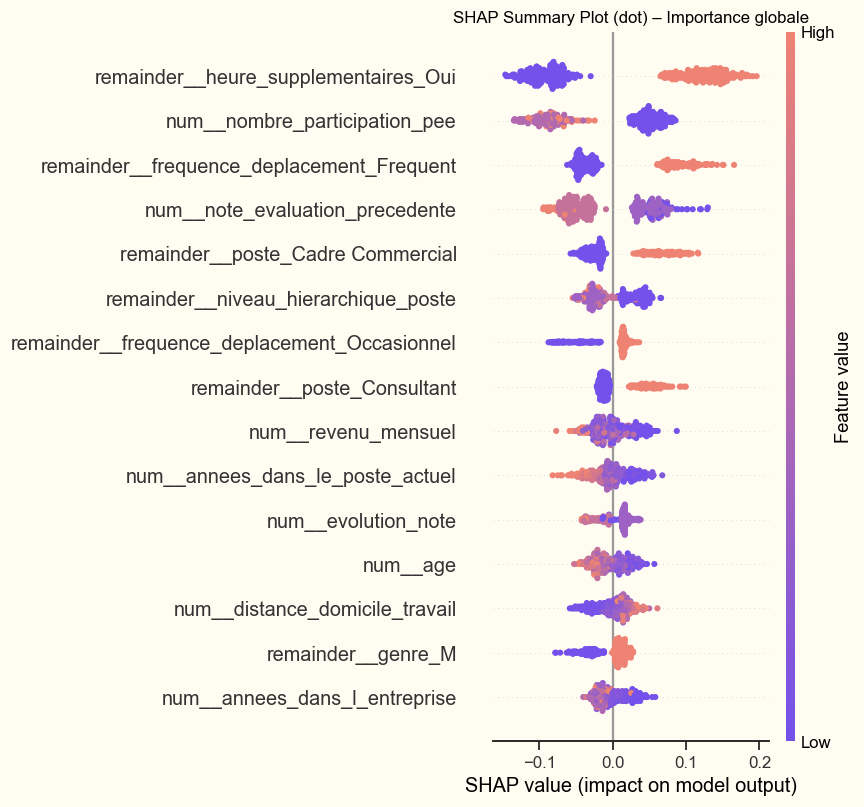

In [13]:
warnings.filterwarnings("ignore", category=UserWarning)

# --- Entraînement global ---
best_pipe.fit(X_full, y_full)
fitted_model = best_pipe.named_steps['clf']

# === Calcul et affichage global ===
cmap_custom = make_diverging_cmap(Theme.PRIMARY, Theme.SECONDARY)
shap_values, X_transformed, feature_names = shap_global(best_pipe, X_full, y_full, cmap=cmap_custom)


[INFO] Interprétation locale SHAP – individu 202


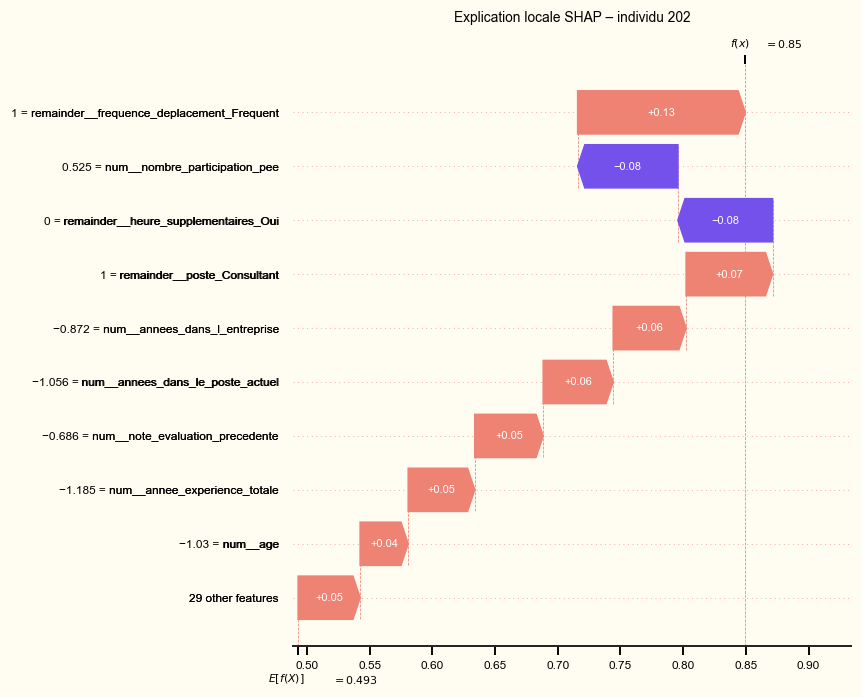


[INFO] Interprétation locale SHAP – individu 146


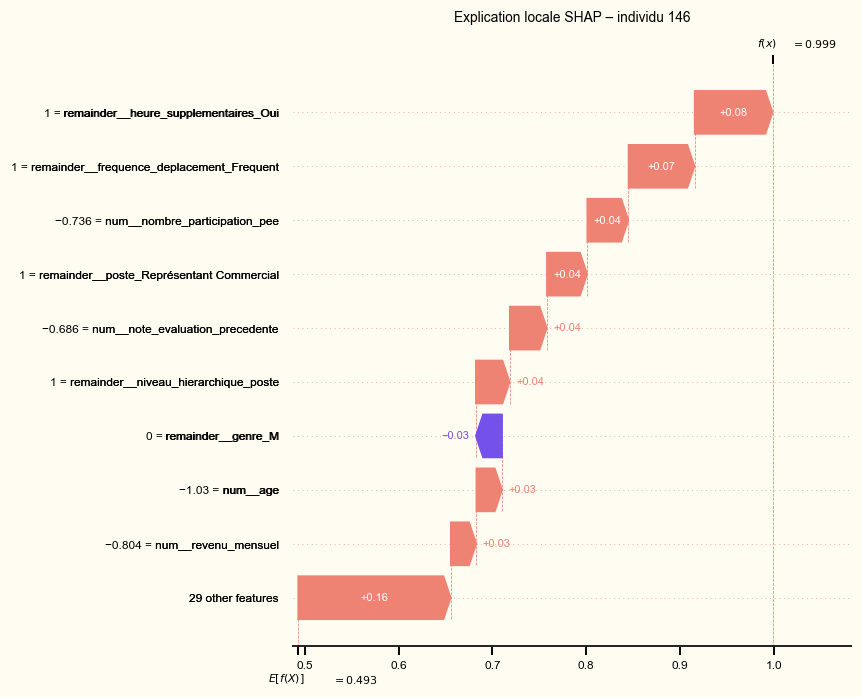


[INFO] Interprétation locale SHAP – individu 109


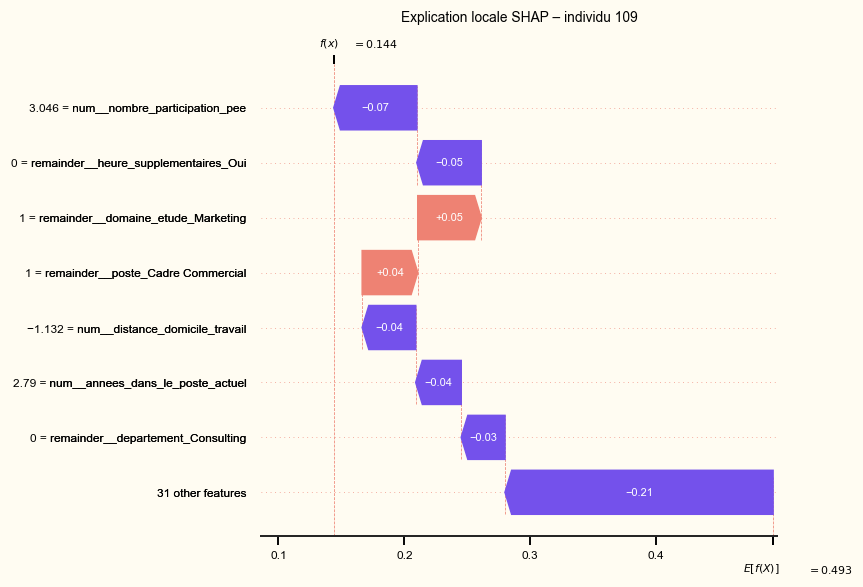


[INFO] Interprétation locale SHAP – individu 149


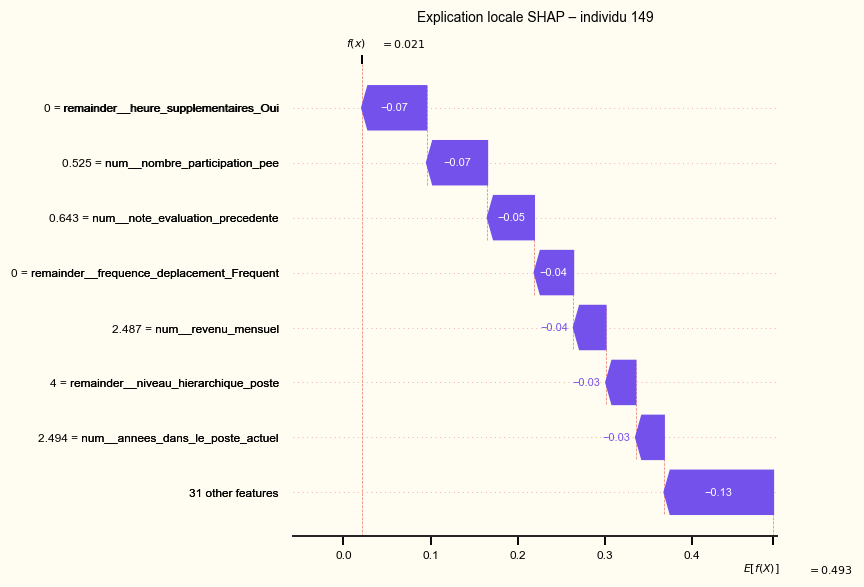

In [14]:
# Cas général : individu à plus fort impact
idx_impact = np.argmax(np.sum(np.abs(shap_values.values), axis=1))
shap_local(idx_impact, shap_values, cmap=cmap_heatmap)

# Cas : individu à forte probabilité de départ
y_proba_all = best_pipe.named_steps['clf'].predict_proba(X_transformed)[:, 1]
idx_highrisk = int(np.argmax(y_proba_all))
shap_local(idx_highrisk, shap_values, cmap=cmap_heatmap)

# Cas : individu choisi manuellement
CUSTOM_INDEX = 109
shap_local(CUSTOM_INDEX, shap_values, max_display=8, cmap=cmap_heatmap)

# Cas : individu à plus faible probabilité de départ 
y_proba_all = best_pipe.named_steps['clf'].predict_proba(X_transformed)[:, 1]
idx_lowrisk = int(np.argmin(y_proba_all))
shap_local(idx_lowrisk, shap_values, max_display=8, text_scale=0.6, cmap=cmap_heatmap)
